RNN sur Time séries
  - data set de la fred: base de donées économiques de la réserve fédérale comportant des données de ventes pour des magasins.
  - observation d'un cycle de vente et il semble y a voir un pic chaque année autour décembre car il s'agit de      fête de noel et de vacance dans de nombreux pays
  - Voir si le RNN peut prédire une sorte de saisonnalité en se basant sur les points de données historiques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('RSCCASN.csv',parse_dates=True,index_col='DATE')

In [3]:
df
# la date est lue sous une chaîne de caractère objet 
# si on veut que ce soit un time stamp spécifique on peut ajouter 2 paramètre à read.csv

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [4]:
# renomage de la colonne en sales 
df.columns=['Ventes']

<AxesSubplot:xlabel='DATE'>

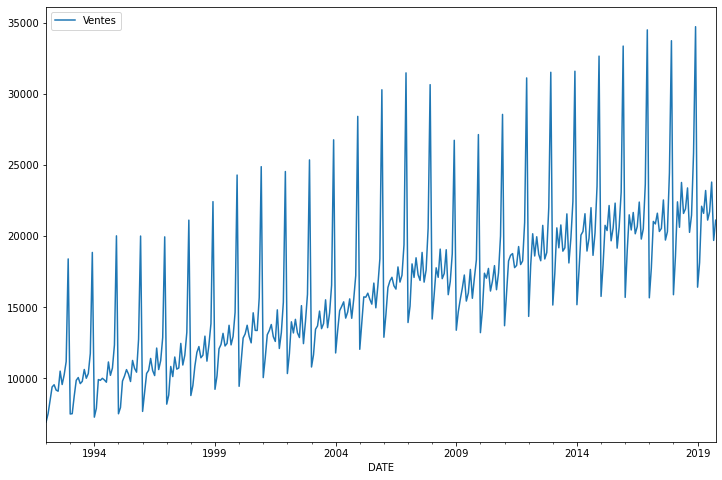

In [5]:
df.plot(figsize=(12,8))

In [6]:
# Trouver où séparer les ensembles d'entraînement et de test
# prendre une année d'info car il s'agit d'un cycle annuel
# on doit donc essayer de prédire une de ses saisonalité
# on va choisir un peu plus d'une année: 18 mois
# on a 334 points de données
# on va faire de mois en mois ce qui signifie 12 lignes pour une année donc 18 lignes pur 1an et demi
len(df)

334

In [7]:
len(df)-18

316

In [8]:
test_size=18# pour la taille de mon set de test
test_ind=len(df)-test_size

In [9]:
# Utilisation de la localisation par entier avec la méthode iloc
train=df.iloc[:test_ind]
test=df.iloc[test_ind:]

In [10]:
test


,Ventes
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [11]:
# Mettre à l'échelle les données
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [12]:
scaler_train=scaler.fit_transform(train)
scaler_test=scaler.transform(test)

In [13]:
# création des generator de timeseries
# s'assurer que la longeur de mon batch est inférieur à la taille du  set de test: len(test)=18, donc la longeur des batchs doivent < à 18
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length=12# longeur réelle des batchs
generator=TimeseriesGenerator(scaler_train,scaler_train, length=length,batch_size=1)

2022-04-21 14:27:02.321186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 14:27:02.321214: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [14]:
# regardons à quoi ressemble de 1er batch
X,y=generator[0]

In [15]:
len(X[0])# on note une saisonalité et on veut prédire la valeur suivante:y
# étant donné la longeur de 12 mois pédir  le 13 ème mois 

12

# Création du modèle

In [16]:
# création du modèle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
# utilisation d'une seule feature: les données de ventes historiques
# input_shape: égale à la longeur du batch et le nombre de features
# la fonction de perte(loss) pour une varaible continue: erreur quadratique moyenne

n_features=1

model= Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

2022-04-21 14:28:57.035922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-21 14:28:57.035958: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-21 14:28:57.035985: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hprisser): /proc/driver/nvidia/version does not exist
2022-04-21 14:28:57.036206: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# cr&éation d'un mécanisme d'arrêt anticipé pour contrôler la val_loss
# un RNN prend plus de temps à entraîner et prend bcp d'epochs pour celà d'où l'ajout d'un mécanisme d'arrêt anticipé
# paramètre patience: nombre d'epochs que nous voulons attendre après tout changement négatif dans la métrique suivie
# nombre d'epochs sans aucune amélioration après quoi l'entraînement sera stoppé
from tensorflow.keras.callbacks import EarlyStopping
early_stop= EarlyStopping(monitor='val_loss', patience=2)

In [18]:
# création du générateur pour les donneés de validation
#batch_size=1: signiffie un tableau pour X et un tableau pour y
length=12
generator=TimeseriesGenerator(scaler_train,scaler_train,length=length,batch_size=1)# generator d'entrâinement
validation_generator=TimeseriesGenerator(scaler_test,scaler_test, length=length,batch_size=1)# generator de validation sur les données test
# ce qui permet d'obtenir la perte de validation pendant l'entraînement et l'arrêt anticipé si besoin

In [19]:
# Alimentation du modèle avec le générateur
model.fit(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 3s 5ms/step - loss: 0.0239 - val_loss: 0.0041
Epoch 2/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0174 - val_loss: 0.0231
Epoch 3/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0100 - val_loss: 0.0848


In [20]:
# Visualisation des pertes
losses=pd.DataFrame(model.history.history)

<AxesSubplot:>

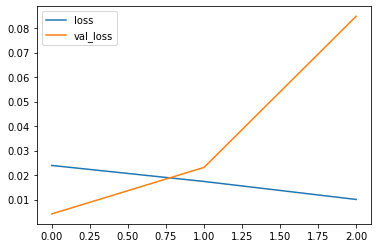

In [21]:
losses.plot()

In [22]:
# Voir les performances sur les donnés test

# Création de la boucle for
test_prediction=[]# on part d'une liste vide
# premier batch d'évaluation
first_eval_batch=scaler_train[-length:]# longueur de batch est de 12: saisir 12 derniers mois du set d'entraînement pour prédire un mois dans le futur par def le 1er point du set de test
# batch actuel
current_batch=first_eval_batch.reshape((1,length,n_features))# transformation avec.reshape() basé sur la longeur length et le n_features et on assigne à current_batch

for i in range(len(test)):# boucle sur len(test)
    # obtenir la prédiction avec 1 time stamp d'avance[0] pour ne saisir que le nombre au lieu du tableau, on prédit avec 1 unité de temps d'avance
  current_pred=model.predict(current_batch)[0]# première prédiction sur le bacth actuel
  test_prediction.append(current_pred)# stockage de la prediction actuelle dans la liste test_prediction
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)# 

In [23]:
# Faire la transformation inverse des valeurs de prédiction pour les obtenir à la vrai echelle
true_prediction=scaler.inverse_transform(test_prediction)

In [24]:
#Ajout de ces valeurs à une nouvelle colonne du data frame test
test['prediction']=true_prediction

/tmp/ipykernel_201649/1368121680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction']=true_prediction


In [25]:
test

,Ventes,prediction
DATE,,
2018-05-01,23764,28099.872879
2018-06-01,21589,27649.023611
2018-07-01,21919,28391.909070
2018-08-01,23381,30539.085381
2018-09-01,20260,28907.159279
2018-10-01,21473,30569.493881
2018-11-01,25831,37678.097167
2018-12-01,34706,45911.402864
2019-01-01,16410,27846.041860


<AxesSubplot:xlabel='DATE'>

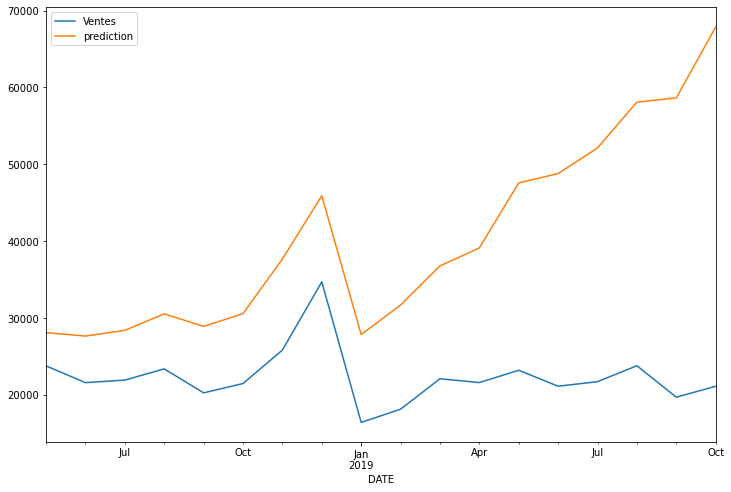

In [26]:
test.plot(figsize=(12,8))
# Nos prédictions semblent plutôt bonne étant donné qu'à la fn on prédit que sur des prédictions
#La tendance de saisonalité générale est toujours présente 
# expérimentation avec la fonction par défaut LSTM(tanh)/ supprimer ou ajouter plus neuronne avec LSTM

 # Utilisation du modèle pour faire les prédictions futures avec des nouvelles données
- Etapes à suivre :
     - mettre à l'échelle
     - réentrainer sur toutes nos données
     - faire l'entraînement ensuite la prévision

In [27]:
#:mettre à l'échelle/
full_scaler=MinMaxScaler()
scaler_full_data=full_scaler.fit_transform(df)

In [28]:
# Création du générateur
length=12
generator_full=TimeseriesGenerator(scaler_full_data,scaler_full_data,length=length,batch_size=1)

In [29]:
# création du model
model=Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))# la dernière couche de sortie

model.compile(loss='mse',optimizer='adam')
model.fit(generator_full,epochs=3)

Epoch 1/3
322/322 [==============================] - 3s 7ms/step - loss: 0.0261
Epoch 2/3
322/322 [==============================] - 2s 6ms/step - loss: 0.0164
Epoch 3/3
322/322 [==============================] - 1s 4ms/step - loss: 0.0084


In [30]:
# Faire les prévisions dans le futur
# Création de la boucle for

forecast=[]# on part d'une liste vide
# Remplacez les périodes par la durée de prévision que l'on souhaite / la longeur de prévison doit être égale à la longeur de test en général
periods=12
# premier batch d'évaluation
first_eval_batch=scaler_train[-length:]# longueur de batch est de 12: saisir 12 derniers mois du set d'entraînement pour prédire un mois dans le futur par def le 1er point du set de test
# batch actuel
current_batch=first_eval_batch.reshape((1,length,n_features))# transformation avec.reshape() basé sur la longeur length et le n_features et on assigne à current_batch

for i in range(periods):# boucle sur len(test)
    # obtenir la prédiction avec 1 time stamp d'avance[0] pour ne saisir que le nombre au lieu du tableau, on prédit avec 1 unité de temps d'avance
  current_pred=model.predict(current_batch)[0]# première prédiction sur le bacth actuel
  forecast.append(current_pred)# stockage de la prediction actuelle dans la liste test_prediction
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [31]:
# Faire la transformation inverse des valeurs de prédiction pour les obtenir à la vrai echelle
forecast=full_scaler.inverse_transform(forecast)

In [32]:
df

,Ventes
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [33]:
forecast
# on a notre série de valeur qui va jusque 2020, sachant qu'on a aucune idée si nos valeurs sont correctes ou non
# Ce sont nos prévisions sur un futur inconnu de notre data set qui allait jusqu octobre 2019

array([[21909.17346287],
       [21117.59290171],
       [21364.50760508],
       [22790.33971786],
       [20991.38808107],
       [21557.91452312],
       [25660.45832825],
       [33123.70449591],
       [18427.50053906],
       [20133.20374179],
       [22773.5023675 ],
       [21576.38049364]])

In [34]:
# ajouter à ces valeur un index de temps
# determination de la fréquence en se basant sur le data set
forecast_index=pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [35]:
# création d'un df qui combine cet index avec les valeurs de forecast
forecast_df=pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])

In [36]:
forecast_df

,Forecast
2019-11-01,21909.173463
2019-12-01,21117.592902
2020-01-01,21364.507605
2020-02-01,22790.339718
2020-03-01,20991.388081
2020-04-01,21557.914523
2020-05-01,25660.458328
2020-06-01,33123.704496
2020-07-01,18427.500539
2020-08-01,20133.203742


<AxesSubplot:>

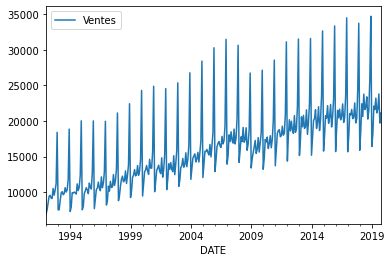

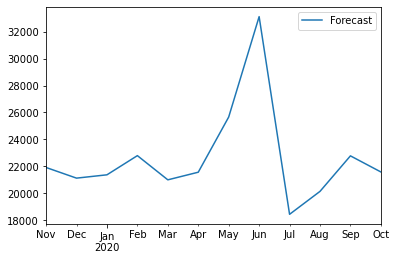

In [37]:
# tracage des graphiques
# on obtient deux graphs, l'un pour les données d'origine et l'autre pour les prédictions dans le futur
df.plot()
forecast_df.plot()